## Part 0: Data Processing and EDA

### Importing Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from random import *
from math import log
from pandas.io.json import json_normalize
import copy
pd.set_option('display.max_columns', None)

from scipy.stats.stats import pearsonr   
%matplotlib inline

In [2]:
with open('dataset/business.json') as f:
    business_data = [json.loads(line) for line in f]
with open('dataset/user.json') as f:
    user_data = [json.loads(line) for line in f]  

In [3]:
# preprocessed file with reviews only for restaurants
with open('dataset/restaurant_reviews_trimmed.json') as f:
    review_data = [json.loads(line) for line in f]

In [4]:
# convert array to list
restaurant_reviews = review_data[0]

In [5]:
# pull just restaurant data from business data
restaurant_data = [x for x in business_data if 'Restaurants' in x['categories']]

In [6]:
del review_data
del business_data

### EDA

In [7]:
restaurant_df = json_normalize(restaurant_data)

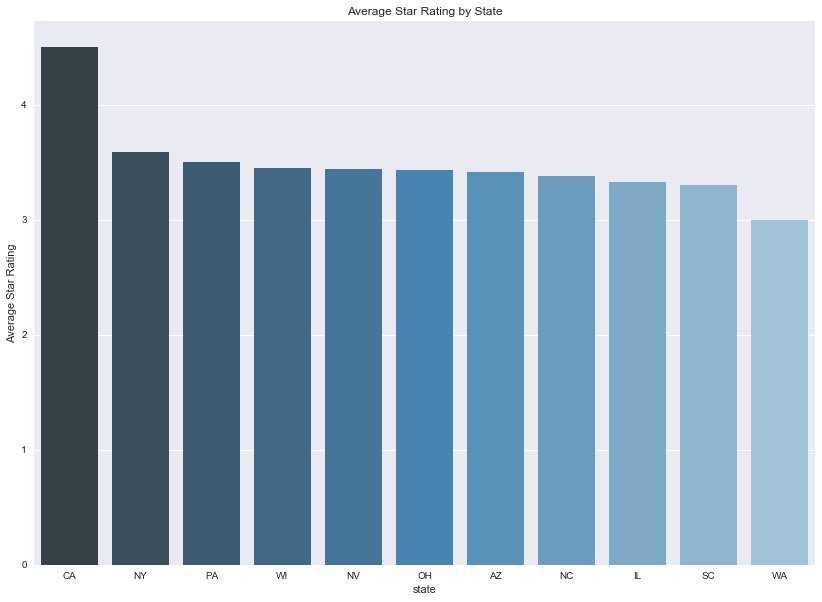

In [8]:
statemeans_df = restaurant_df.groupby('state', as_index=False)['stars'].mean()
statemeans_df = statemeans_df.sort_values(by=['stars'], ascending=False)
states = [ "AK","AL","AR","AS","AZ","CA","CO","CT","DC","DE","FL","GA","GU","HI","IA","ID","IL","IN",
"KS","KY","LA","MA","MD","ME","MI","MN","MO","MS","MT","NC","ND","NE","NH","NJ","NM","NV","NY","OH",
"OK","OR","PA","PR","RI","SC","SD","TN","TX","UT","VA","VI","VT","WA","WI","WV","WY"]
statemeans_df = statemeans_df[statemeans_df['state'].isin(states)]
fig, ax = plt.subplots(figsize=(14,10))
ax=sns.barplot(x='state',y='stars',palette="Blues_d", data=statemeans_df)
ax.set_ylabel('Average Star Rating')
ax.set_title('Average Star Rating by State')

/Users/PeterAyala/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


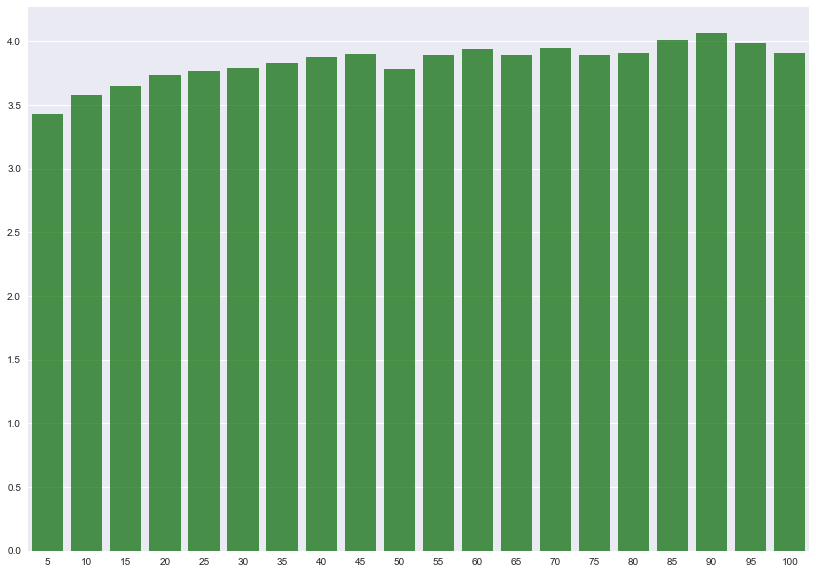

In [9]:
numbermeans_df = restaurant_df.groupby('review_count', as_index=False)['stars'].mean()
#plt.plot(numbermeans_df['review_count'], numbermeans_df['stars'])

slices = np.linspace(0, len(numbermeans_df), len(numbermeans_df)/45+1, True).astype(np.int)
counts = np.diff(slices)
mean = np.add.reduceat(numbermeans_df['stars'], slices[:-1]) / counts
fig, ax = plt.subplots(figsize=(14,10))
ax = sns.barplot(x=[x*10 for x in range(len(mean))], y=mean, color = 'green', alpha=0.75)
ax.set(xticklabels = [(x+1)*5 for x in range(21)]);

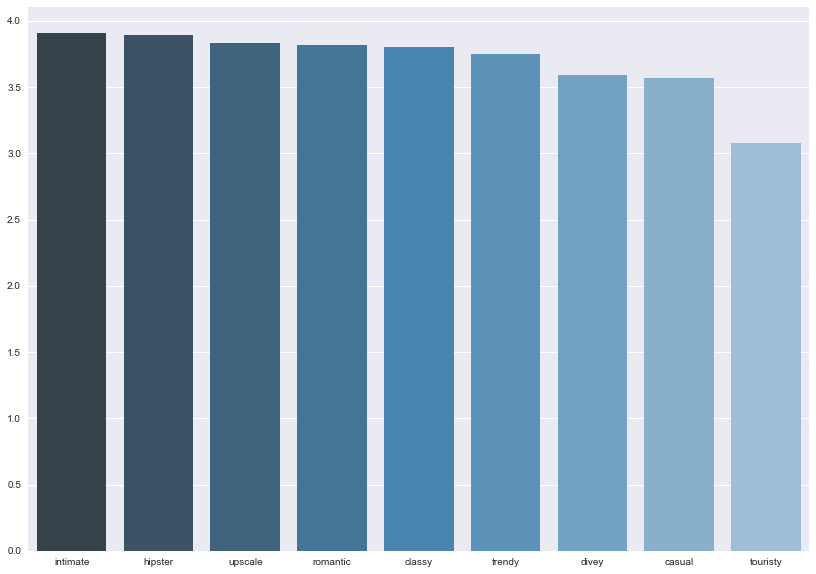

In [10]:
ambience_headers=restaurant_df.columns[4:13].values
ambience_dict = {}

for item in ambience_headers:
    trimmed_name = item[20:]
    ambience_dict[trimmed_name] = restaurant_df.loc[restaurant_df[item] == True, 'stars'].mean()

pairs = zip(list(ambience_dict.keys()), list(ambience_dict.values()))
pairs = sorted(pairs, key=lambda x: x[1], reverse=True)
ambiences, means = zip(*pairs)
fig, ax = plt.subplots(figsize=(14,10))
ax=sns.barplot(x=ambiences, y=means, palette='Blues_d')

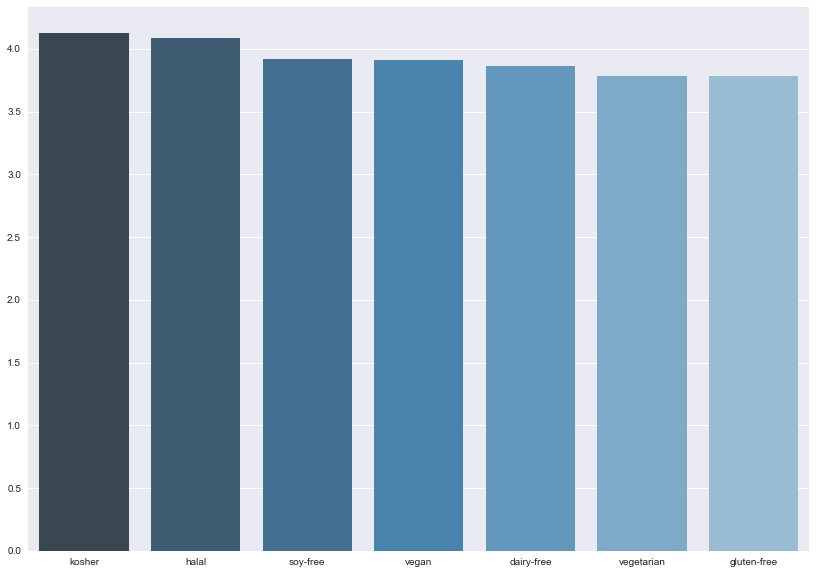

In [11]:
dietary_headers = restaurant_df.columns[34:41]
dietary_dict={}

for item in dietary_headers:
    trimmed_name = item[31:]
    dietary_dict[trimmed_name] = restaurant_df.loc[restaurant_df[item] == True, 'stars'].mean()

pairs = zip(list(dietary_dict.keys()), list(dietary_dict.values()))
pairs = sorted(pairs, key=lambda x: x[1], reverse=True)
dietaryrestrictions, means = zip(*pairs)
fig, ax = plt.subplots(figsize=(14,10))
ax=sns.barplot(x=dietaryrestrictions, y=means, palette='Blues_d')

In [12]:
def create_pivot_restaurant(df, cat):
    sub_df = df[[cat,'stars']]
    pivot = pd.pivot_table(sub_df,index=[cat], aggfunc=np.sum) 
    pivot['TOTAL_COUNT'] = sub_df[cat].value_counts() 
    pivot['AVG_RATING'] = pivot['stars']/pivot['TOTAL_COUNT'] 
    return pivot

In [13]:
d = create_pivot_restaurant(restaurant_df, 'attributes.Alcohol')
d

,stars,TOTAL_COUNT,AVG_RATING
attributes.Alcohol,,,
beer_and_wine,21917.5,6066,3.613172
full_bar,55407.5,15853,3.495080
none,63020.5,18316,3.440735


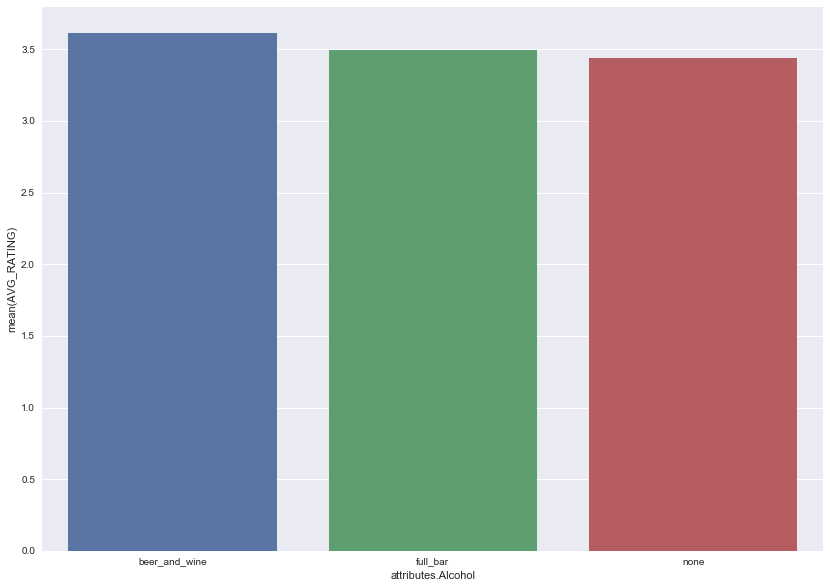

In [14]:
fig, ax = plt.subplots(figsize=(14,10))
sns.barplot(d.index, d['AVG_RATING'], ax = ax)

In [24]:
restaurant_df_v2 = restaurant_df
d = create_pivot_restaurant(restaurant_df_v2, 'attributes.RestaurantsAttire')
d

,stars,TOTAL_COUNT,AVG_RATING
attributes.RestaurantsAttire,,,
casual,149545.5,43276,3.455622
dressy,5207.0,1397,3.727273
formal,413.5,125,3.308000


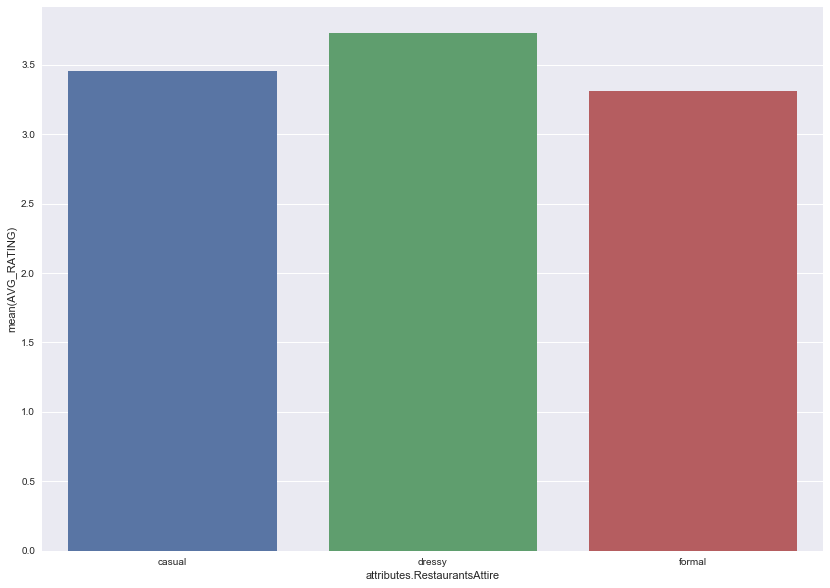

In [25]:
fig, ax = plt.subplots(figsize=(14,10))
sns.barplot(d.index, d['AVG_RATING'], ax = ax)

In [26]:
r = create_pivot_restaurant(restaurant_df_v2, 'attributes.RestaurantsPriceRange2')
r

,stars,TOTAL_COUNT,AVG_RATING
attributes.RestaurantsPriceRange2,,,
1.0,65102.5,19013,3.424105
2.0,86878.5,24919,3.486436
3.0,10331.5,2845,3.631459
4.0,1998.0,537,3.720670


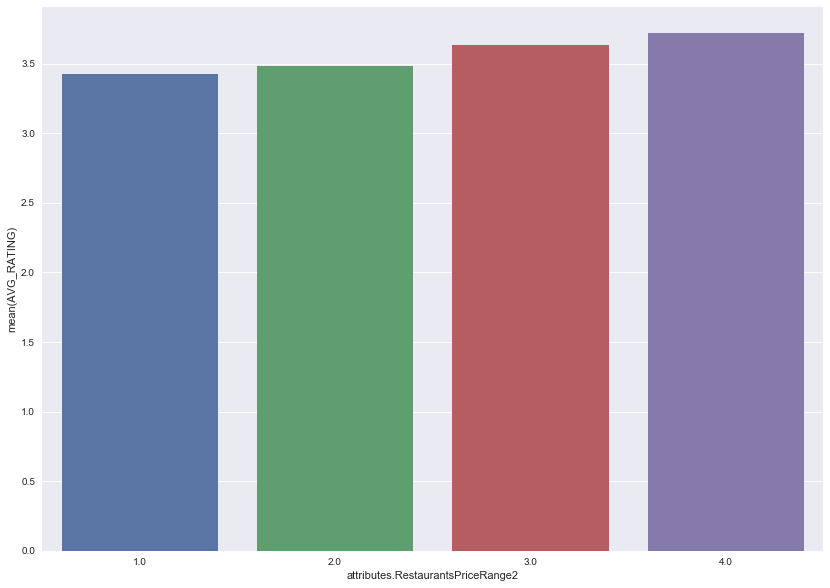

In [27]:
fig, ax = plt.subplots(figsize=(14,10))
sns.barplot(r.index, r['AVG_RATING'], ax = ax);

In [28]:
ambience_ratings = {}
for a in ['attributes.Ambience.casual', 'attributes.Ambience.classy', 'attributes.Ambience.divey',
          'attributes.Ambience.hipster', 'attributes.Ambience.intimate', 'attributes.Ambience.romantic',
          'attributes.Ambience.touristy', 'attributes.Ambience.trendy', 'attributes.Ambience.upscale']:
    ambience_ratings[a] =  create_pivot_restaurant(restaurant_df, a).iloc[1]

In [29]:
ambience_df = pd.DataFrame.from_dict(ambience_ratings, orient = 'index')
ambience_df

,stars,TOTAL_COUNT,AVG_RATING
attributes.Ambience.casual,64843.5,18166.0,3.569498
attributes.Ambience.classy,3123.5,821.0,3.804507
attributes.Ambience.divey,3012.5,838.0,3.594869
attributes.Ambience.hipster,3186.0,818.0,3.894866
attributes.Ambience.intimate,1985.5,508.0,3.908465
attributes.Ambience.romantic,1904.5,499.0,3.816633
attributes.Ambience.touristy,553.5,180.0,3.075000
attributes.Ambience.trendy,6536.0,1741.0,3.754164
attributes.Ambience.upscale,1338.5,349.0,3.835244


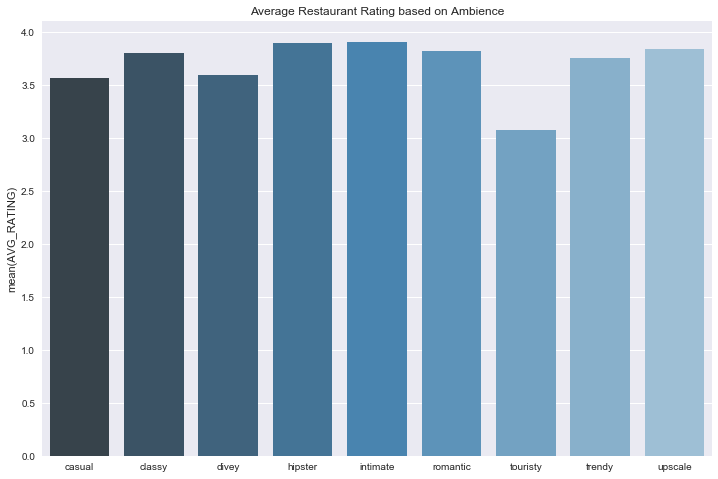

In [30]:
fig, ax = plt.subplots(figsize=(12,8))
index = [x.split('.')[2] for x in ambience_df.index]
sns.barplot(index, ambience_df['AVG_RATING'], ax = ax, palette = "Blues_d")
ax.set_title('Average Restaurant Rating based on Ambience');

In [31]:
parking_ratings = {}
for a in ['attributes.BusinessParking.garage', 'attributes.BusinessParking.lot', 'attributes.BusinessParking.street',
          'attributes.BusinessParking.valet', 'attributes.BusinessParking.validated']:
    parking_ratings[a] =  create_pivot_restaurant(restaurant_df_v2, a).iloc[1]
parking_df = pd.DataFrame.from_dict(parking_ratings, orient = 'index')
parking_df

,stars,TOTAL_COUNT,AVG_RATING
attributes.BusinessParking.garage,7593.5,2171.0,3.497697
attributes.BusinessParking.lot,58328.0,16437.0,3.548579
attributes.BusinessParking.street,32030.5,8676.0,3.691851
attributes.BusinessParking.valet,3769.5,1039.0,3.628008
attributes.BusinessParking.validated,862.5,238.0,3.623950


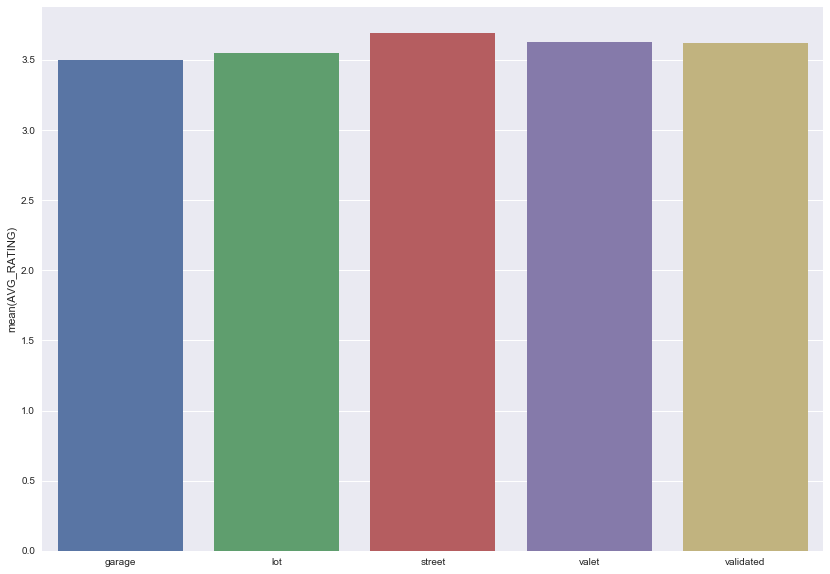

In [32]:
fig, ax = plt.subplots(figsize=(14,10))
index = [x.split('.')[2] for x in parking_df.index]
sns.barplot(index, parking_df['AVG_RATING'], ax = ax);

In [33]:
drivethru = create_pivot_restaurant(restaurant_df, 'attributes.DriveThru')
drivethru

,stars,TOTAL_COUNT,AVG_RATING
attributes.DriveThru,,,
False,12276.5,3686,3.330575
True,6171.0,2352,2.623724


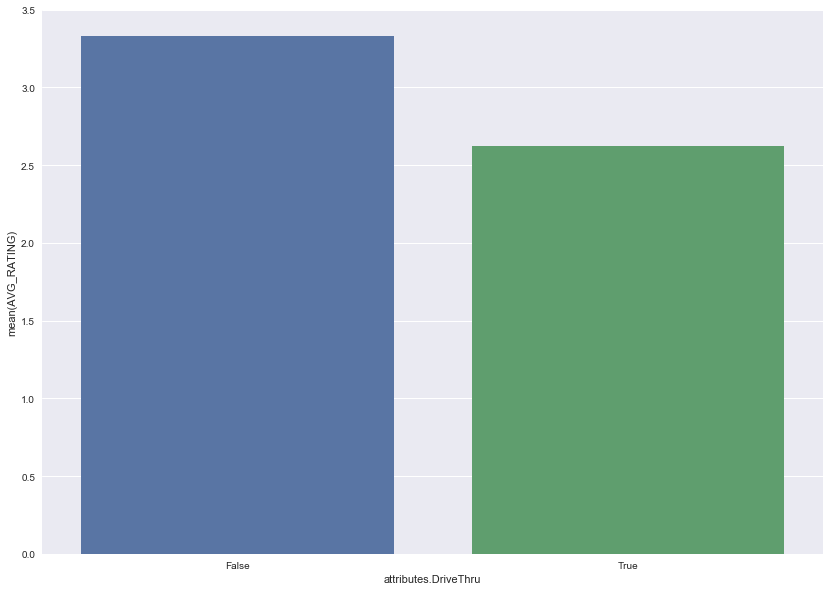

In [34]:
fig, ax = plt.subplots(figsize=(14,10))
sns.barplot(drivethru.index, drivethru['AVG_RATING'])

In [35]:
create_pivot_restaurant(restaurant_df, 'attributes.GoodForKids')

,stars,TOTAL_COUNT,AVG_RATING
attributes.GoodForKids,,,
False,26598.0,7640,3.481414
True,130648.0,37796,3.456662


In [36]:
good_for_meals = {}
for a in ['attributes.GoodForMeal.breakfast', 'attributes.GoodForMeal.brunch', 
          'attributes.GoodForMeal.dessert', 'attributes.GoodForMeal.dinner', 'attributes.GoodForMeal.latenight',
          'attributes.GoodForMeal.lunch', 'attributes.HappyHour']:
    good_for_meals[a] =  create_pivot_restaurant(restaurant_df, a).iloc[1]
    
good_for_meals_df = pd.DataFrame.from_dict(good_for_meals, orient = 'index')
good_for_meals_df

,stars,TOTAL_COUNT,AVG_RATING
attributes.GoodForMeal.breakfast,12970.0,3722.0,3.484686
attributes.GoodForMeal.brunch,12790.5,3549.0,3.603973
attributes.GoodForMeal.dessert,5325.0,1513.0,3.519498
attributes.GoodForMeal.dinner,54958.5,15299.0,3.592294
attributes.GoodForMeal.latenight,8282.5,2473.0,3.349171
attributes.GoodForMeal.lunch,63607.5,17817.0,3.570045
attributes.HappyHour,14500.0,4185.0,3.464755


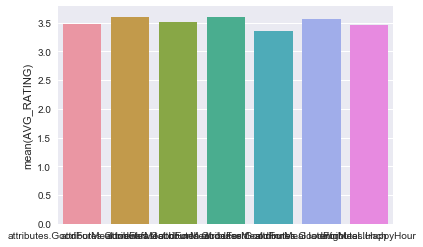

In [37]:
sns.barplot(good_for_meals_df.index, good_for_meals_df['AVG_RATING'])

## Part 1: Create a Baseline

### Getting global averages

In [ ]:
user_total = [x['average_stars'] for x in user_data]
global_user_average = sum(user_total)/len(user_total)
print (global_user_average)

In [ ]:
restaurant_total = [x['stars'] for x in restaurant_data]
global_restaurant_average = sum(restaurant_total)/len(restaurant_total)
print (global_restaurant_average)

In [ ]:
reviews_total = [x['stars'] for x in restaurant_reviews]
global_review_average = sum(reviews_total)/len(reviews_total)
print (global_review_average)

### Getting restaurant and user biases

In [ ]:
# for easy lookup based on user id
user_dict = {}
for item in user_data:
    user_id = item['user_id']
    user_dict[user_id] = item

In [ ]:
user_deviations = {}
for item in user_data:
    user_id = item['user_id']
    user_deviations[user_id] = item['average_stars'] - global_user_average
    

In [ ]:
restaurant_deviations = {}
for item in restaurant_data:
    rest_id = item['business_id']
    restaurant_deviations[rest_id] = item['stars'] - global_restaurant_average

### Rating the Model

In [ ]:
#getting a random evaluation set of 20000
evaluation_set = np.random.choice(restaurant_reviews, size = 20000)


In [ ]:
evaluation_df = pd.DataFrame(list(evaluation_set))

In [ ]:
evaluation_df = evaluation_df.drop(['cool', 'date', 'funny','text','useful'], axis = 1)


In [ ]:
def baseline(user_id, business_id):
    pred = global_review_average + user_deviations[user_id] + restaurant_deviations[business_id]
    return pred

In [ ]:
evaluation_df['baseline_pred'] = [baseline(x,y) for (x,y) in zip(evaluation_df['user_id'],evaluation_df['business_id'])]

In [ ]:
score = metrics.mean_squared_error(evaluation_df['stars'], evaluation_df['baseline_pred'])
print (score)

In [ ]:
del evaluation_df

## Part 2: Create a Regularized Regression

### Creating training, validating, and testing sets

In [ ]:
# take 100000 reviews as sample
data_array = (np.random.choice(restaurant_reviews, size = 100000))
data_set = list(data_array)

In [ ]:
# find all categories for one-hot encoding purposes
from collections import Counter
all_categories = []
for r in restaurant_data:
    if 'Restaurants' in r['categories']:
        for c in r['categories']:
            all_categories.append(c)

In [ ]:
# take 150 most popular categories
counts = list (Counter(all_categories).items())
counts.sort(key=lambda x: x[1], reverse = True)
most_popular = [x[0] for x in counts[:150]]


In [ ]:
expanded_reviews = copy.deepcopy(data_array)

In [ ]:
# add business and user info
for review in expanded_reviews:
    #print (review)
    restaurant = review['business_id']
    user = review['user_id']
    restaurant_info = restaurant_dict[restaurant]
    #print (restaurant_info)
    user_info = user_dict[user]
    for attribute in restaurant_info:
        #print (attribute)
        if attribute not in ['is_open', 'latitude','longitude','name','business_id',
                             'neighborhood','address','city','postal_code','hours']:
            if attribute == 'categories':
                for c in most_popular:
                    if c in restaurant_info[attribute]:
                        review['R_' +  c] = 1
                    else:
                        review['R_' +  c] = 0
            else:         
                review['R_' + attribute] = restaurant_info[attribute]
    for attribute in user_info:
        if attribute not in ['user_id','name']:   
            if attribute == 'friends':
                review['U_friends'] = len(user_info[attribute])
            elif attribute == 'yelping_since':
                review['U_yelping_since'] = user_info[attribute][:4]
            elif attribute == 'elite':
                if user_info[attribute]:
                    review['U_elite'] = True
                else:
                    review['U_elite'] = False        
            else:
                review['U_' + attribute] = user_info[attribute] 

In [ ]:
# create pandas dataframe
flatframe = json_normalize(expanded_reviews)
flatframe = flatframe.drop(['text','useful','funny','cool','date'], axis=1)

In [ ]:
# change user since
flatframe['U_years_yelping'] = [2015 - int(x) for x in flatframe['U_yelping_since']]
flatframe.drop(['U_yelping_since'],axis = 1, inplace = True)

In [ ]:
# drop ids
flatframe = flatframe.drop(['business_id', 'review_id', 'user_id'], axis = 1)

In [ ]:
#one hot encode state
flatframe = pd.get_dummies(flatframe, columns = ['R_state'])

In [ ]:
# train test split
msk = np.random.rand(len(flatframe)) < 0.5
data_train = flatframe[msk]
data_test = flatframe[~msk]

### Making the Model